# Remote Execution of workflows and external tasks

## Two methods for remote execution

Based on a host configuration system that defines ways to communicate with remote hosts, SoS allows you to execute complete or part of workflows on remote servers or task queues. Here we define

* A **host** as a local or remote machine that can be accessed with commands such as `scp`, `ssh`, and `rsync`.
* A **queue** as a task queue such as [PBS](http://www.pbspro.org/), [Torque](http://www.adaptivecomputing.com/products/open-source/torque/), [IBM LSF](https://www.ibm.com/support/knowledgecenter/en/SSETD4/product_welcome_platform_lsf.html), and [RQ](http://python-rq.org/) on a local or remote host that can queue and execute tasks. Direct execution of tasks on remote hosts is also considered a queue so any host can be used as a task queue.

There are two ways to execute workflows on a remote host,

* Use `sos run -r HOST` (or `%run -r` or `%sosrun -r` in Jupyter) to copy a script to remote host and execute the entire workflow remotely. All input and dependent files should be on remote host, and result files are not sychronized to local host.
* Use `sos run -q QUEUE` (or `%run -q` or `%sosrun -q` in Jupyter) to submit individual **tasks** of workflows to remote task queues. The workflow is still executed locally. Input, output, and dependent files of tasks will be synchronized to the remote host if necessary.

These two methods could be used in combination if the remote host is configured to be able to submit tasks to a local task queue or to a third host.

### Host configuration

To execute a sos workflow or task on a remote host, you will need to prepare the host as follows:

1. Set up public key authentication between local and remote host so that you can log in to remote host without being prompted for password.
2. Install SoS on both local and remote hosts.
3. Make sure you have `ssh`, `scp`, and `rsync` installed on local host. For windows, you might want to install these tools with [msys2](http://www.msys2.org/) or enable Ubuntu Linux Shell (windows 10 only, need to turn on developer mode).
4. Set up `$PATH` on the remote host to make sure sos (and other commands that you would like to execute) could be executed remotely with commands like
```
% ssh remote-host "bash --login -c 'sos status'"
```
sos uses `bash --login` to execute commands on remote host to make sure `$PATH` etc are properly set up. This requires `bash` command on remote host so it is not yet possible to execute workflows on a windows host.


You then need to add the host to a SoS configuration file. SoS automatically loads global configuration files `~/.sos/hosts.yml`, `~/.sos/config.yml`, and a local configuration file `./config.yml`. You can also put your settings in any configuration file and specify it with option `-c`. `~/.sos/hosts.yml` is designed to record all host-related configurations and should be used for this purpose.

The configuration file could be edited manually if you are familiar with the YAML format. Otherwise you can use the `sos config` command to add or modify settings. For example, command

```bash
sos config --hosts --set hosts.shark.address username@shark.com
```

would write to `~/.sos/hosts.yml` the following content

```
hosts:
    shark:
        address: username@shark.com
```

This effectively defines a host with alias `shark`. Other than `address`, you will need to define `port` if the server accepts a different port than `22`, `shared` and `paths` to let SoS know how to synchronize files between local and remote hosts, and other items for remote task queues.

You will need to configure both localhost and server to be able to send local jobs to remote servers or task queues. A `localhost` should be defined to point to an existing host definition. For example, if a `OfficeDesktop` is defined in `~/.sos/hosts.yml` as 

```
hosts:
    OfficeDesktop:
        paths:
            home: c:\Users\myuser
    cluster:
        address: url@cluster
        paths:
            home: /home/myuser
             
```

You should use command

```
sos config --global --set localhost OfficeDesktop
```

to define `localhost` as `OfficeDesktop` on your office desktop, and define `localhost` as `cluster` on the cluster if you would like to submit jobs also from the cluster.

### Remote execution of workflows

With proper host configurations, you can execute a workflow on a remote host using option `-r HOST`. For example,

In [2]:
%preview -n test.png
%run -r dev
R:
  set.seed(1)
  x <- 1:100
  y <- 0.029*x + rnorm(100)
  png("test.png", height=400, width=600)
  plot(x, y, pch=19, col=rgb(0.5, 0.5, 0.5, 0.5), cex=1.5)
  abline(lm(y ~ x))
  dev.off()


null device 
          1 



%preview test.png

> Failed to preview file or expression test.png

executes a small R script (a SoS script with a single R action) on a remote host named `dev` (defined in `hosts.yml`). The script executes correctly (with output from `dev.off()` function) but because the workflow is executed remotely, `test.png` will be generated on `dev` and is unavailable for local preview. You can however preview the file with `-r` option of magic `%preview`:

%preview test.png -r dev

> test.png (11.2 KiB):

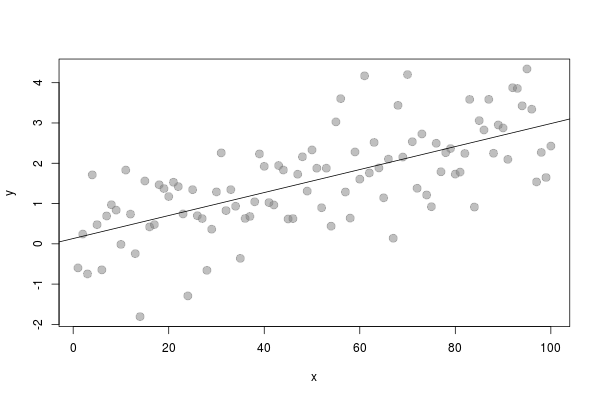

In [3]:
%preview -n test.png -r dev

The command line eqivalence of the commands, if the script is saved as `test.sos`, would be 
```
sos run test.sos -r dev
sos preview test.png -r dev
```

**Note:** when set via `-r` option to a remote batch system such as PBS/Torch, the default `localhost` on the remote machine will have to be configured to use the batch system.

### Execution of external tasks

If a workflow is large, you can define parts of a workflow as **tasks** and execute them on remote servers, clusters, or task queues. The tasks are

* **self-contained** in that they contain all the required information to be executed anywhere.
* **generated and executed dynamically** in that a task would only be generated when all its dependencies have been met.
* **independent of workflows and other tasks**. Tasks are defined by the jobs they are performing and can be shared by different workflows if they happen to perform exactly the same function.
* **can be executed on remote hosts or task queues**. Tasks can be executed directly on a local or remote host, to task queues such as RQ, or be submitted to batch systems such as PBS/Torch, Slurm, and IBM LSF.
* **independent of file systems**. SoS automatically synchronize input, output files and specified files between local and remote systems so you can easily switch from one remote host to another.
* **support remote targets**. If input, depends, or output files are large, you also have the option to process remote targets directly without synchronizing them to local host.

Conceptually speaking, a **step process** consists of everything after the `input` statement. It can be repeated with different **input groups** defined by input options `group_by` or `for_each`. For example, if `bam_files` is a list of bam files,

```
[10]
input: bam_files, group_by=1
output: "${_input}.bai"

run:
    samtools index ${_input}
```

execute a shell script to process each bam file. This is done sequentially for each input file, and is performed by SoS.

You can easily specify part or all of a step process as **tasks**, by prepending the statements with a `task` keyword:


```
[10]
input: bam_files, group_by=1
output: "${_input}.bai"

task:
run:
    samtools index ${_input}
```

This statement declares the rest of the step process as a `task`. For each input file, a task will be created with an ID determined from task content and context (input and output files, variables etc). The task will be by default executed by a local `process` task queue where tasks are started as background processes.

The benefit of executing tasks externally is that the tasks are executed concurrently, on the local machine or a remote server, or be submitted to a task queue. For example, in the previous example, multiple tasks could be executed in parallel (but on the same machine) unless you specify it otherwise as follows

```
[10]
input: bam_files, group_by=1
output: "${_input}.bai"

task: concurrent=False
run:
    samtools index ${_input}
```

You can also use command

```
sos run myscript -q cluster
```
or use option `queue`
```
[10]
input: bam_files, group_by=1
output: "${_input}.bai"

task: queue='cluster'
run:
    samtools index ${_input}
```

to submit the commands to a cluster system to be executed on different computing nodes.

The following figure illustrates the task model of SoS

![job queue](../media/job_queue.svg )

Basically,
1. Tasks are part of step processes.
2. Tasks are managed by task engines, multiple task engines can be used for a single workflow.
3. Task engines generate task files, submit tasks, monitor task status, and return results to SoS workflow.
4. Remote task engines synchronize input files, translate and copy tasks to server, and start the tasks on the remote server.

## Common host configuration

SoS needs to know how to connect to a remote host, how to synchronize files between local and remote hosts, and how to execute commands on the remote host. These should be defined with the following keys:

### `address`

IP address or URL of the host. Note that

* `address` should be ignored for hosts, for example your desktop, that do not accept remote execution.
* If you have a different user name on the the remote host, specify the `address` in the format of `username@hostaddress`.
* SoS does not support username/password authentication so **public key authentication between local and remote hosts is reuired for communication between local and remote host**.
* SoS currently does not support remote execution on windows hosts so no `address` is needed for windows hosts.

### `port`

ssh port of the remote host, which is `22` by default. 

### `shared`

Option `shared` tells SoS which file systems are shared between localhost and some remote hosts so that it does not have to synchronize files under these directories between the hosts.

The `shared` entry should be defined with `name` and `path` pairs in the format of

```
hosts:
    desktop:
    server:
        shared:
            project: /myprojects
            HTFS: /
    worker:
        shared:
            HTFS: /
    server1:
        shared:
            project: /scratch/myprojects
            data: /scratch/data
````

The above cooked configuration says:

1. `desktop` does not share any volume with any other machine so all files need to be transferred.
2. `server` and `worker` shares `HTFS` with directory `/`, so all files are shared.
3. `server` and `server1` share a `project` volume but the volume is mounted at different locations. So files under `myprojects` are not synchronized if you are submitting jobs from `server` to `server1`, and files under `/scratch/myprojects` are not synchronized if you are submitting jobs from `server1` to `server`.


### `paths`

`paths` defines paths that will be translated when a task is executed remotely. For example, your input file on a mac might be `/Users/myuser/project/KS28.fa`, but it should be named `/home/myuser/project/KS28.fa` if it is processed on a remote server. In this case, you should define directories `/Users/myuser` and `/home/myuser` as equivalent directories on the two hosts, using 

```
hosts:
    desktop:
        paths:
            home: /Users/myuser
    server:
        paths:
            home: /home/myuser
```

Multiple entried could be defined and the files would be mapped by the longest mapping path. For example, if you have on the server a shared location for all resources, you could define

```
hosts:
    desktop:
        paths:            
            home: /Users/myuser
            resource: /Users/myuser/resources
    server:
        paths:
            home: /home/myuser
            resource: /shared/resources
```

so that `/Users/myuser/resources/hg19.fa` could be mapped to `/shared/resources/hg19.fa` on the server. Note that `/Users/myuser/resource/hg19.fa` would be mapped to `resource` instead of `home` because `resource` matches longer piece of the input path.

A remote host can be accessible from a local host only if the remote host defines all paths defined by the local host. More specifically, if host A defines path `home` and host B defines paths `home` and `resource`, it is possible to connect from host A to host B using `home`, but not from host B to A because SoS does not know how to map paths under `resource`.

### `path_map` (derived)

With definitions of `shared` and `paths` on both hosts, SoS would derive a set of `path_maps` between all hosts using common keys in `shared` and `path` between the hosts. Actually, when you run 

```
sos status -q
```

to list all host configurations, SoS would list all hosts accessible from `localhost`, with host-specific `path_map`, which is a list of directory mappings between local and remote directories. For example, the `path_map` from `desktop` to `server` using the above example would be

```
/Users/myuser -> /home/myuser
/Users/myuser/resoruces -> /shared/resources
```

Note that if a directory shows in both `shared` and `paths` (e.g. `/scratch` in `shared` and `/scratch/user` in `paths`), files can still be synchronized following `path_map` to a different directory even if they are shared and are already on the remote server.

## Common queue configuration

The above configurations specify on to access, synchronize files and execute commands on a remote host and are enough for it to become a remote host to execute workflows (with option `-r`). More information is needed for the host to execute external tasks, the common task-related configurations include.

### `queue_type`

Option `query_type` determines the type of remote server or job queue. SoS currently supports the following types of job queues:

1. **`process`**: this is the default queue type. Tasks are executed directly, either on local host or on a server.
2. **`pbs`**: A PBS/MOAB/LFS/Slurm cluster system where tasks are submitted using commands such as `qsub`.
3. **`rq`**: A redis queue where tasks are submitted to the rq server and monitored through rq-dashboard.

### `wait_for_task`

Whether or not SoS should wait for the completion of tasks (`true/false`). By default SoS will wait for the completion of tasks submitted in a queue and complete the workflow in one run. Alternatively, SoS would quit after all tasks have been submitted to a queue with `wait_for_task` set to `false`. The workflow can be resumed after tasks have been completed.

This option is set to `True` by default and can be overridden by command line option `-w` (wait) or `-W` (no wait).

### `status_check_interval`

Option `status_check_interval` determines frequency at which SoS checks status of jobs. This is set by default to 2 seconds for `process` queue type, and `10` seconds for all other types. This number should be set to at least `60` for remote servers and longer jobs because it can be a burden to query the status of jobs very frequently.

### `max_running_jobs`

Maximum number of running jobs. This setting controls how SoS releases tasks to job queues and is independent of possible maximum running job settings of individual task queues.

This option is set to half of the number of CPU cores by default and can be overriden by command line option `-J`.

### `max_cores`

Maximum number of processes (an integer) allowed for the queue. A task would fail immediately if it specifies more `cores` than this option. For queues that do not require a `cores` option (e.g. a `process` queue), tasks that use more processes than `max_cores` will be automatically killed.

This option, along with `max_walltime` and `max_mem` that are described below, help prevent the submission of erraneous tasks to the queue. It also helps prevent the execution large jobs on wrong servers, such as the headnode of a cluster system on which only job preparation and submission steps are allowed.

### `max_walltime`

Maximum walltime allowed for the queue. `max_walltime` could be specified as a string in the format of `HH:MM:SS`, or an integer with units `s` (second), `m` (minute), `h` (hour), or `d` (day). A task would fail immediately if it specifies more `walltime` than this option. For queues that do not require a `walltime` option (e.g. a `process` queue), tasks that has exceeded `max_walltime` will be automatically killed.

### `max_mem`

Maximum memory comsumption allowed for the queue. `max_mem` could be specified as an integer (bytes) or a string with units such as `M`, `G`, `MB` etc. A task would fail immediately if it specifies more `mem` than this option. For queues that do not require a `mem` option (e.g. a `process` queue), tasks that use more RAM than `max_mem` will be automatically killed.

### `description`

An optional short description for the queue that will be displayed with commands such as `sos status -q`.

### Hints for `hosts.yml`

As described in section [`SoS Syntax`](SoS_Syntax.html), SoS provides a few features to help maintain and use of host configurations.

First, dictionary `CONFIG` is merged from several configuration files. This allows you to use, for example, use a general host configuration file for all hosts, and make local modifications in host-specific `~/.sos/config.yml` even project-specific `./config.yml`. Also, a system admin could also choose to define all hosts in a network in the site configuration file.

Second, SoS allows you to use string interpolation for keys defined in `CONFIG`. For example, you can define arbitrary key value pairs for the interpolation of commands and templates. For example, if you could define `queue` in `hosts.cluster` as follows

```
hosts:
   cluster:
      queue: long
      job_template: |
#PBS -q ${queue}
...
```

and `queue` will be used in `job_template`.

If the name of a variable matches a runtime variable (e.g. `mem`, `walltime`), its value would be overriden by corresponding runtime variable. This feature can be used to define default values for runtime variables. For example,

```
hosts:
    cluster:
        walltime: '10:00:00'
        job_template: |
    #PBS -l walltime=${walltime}
```

would set a default `walltime` of 10 hours for tasks without specified `walltime`.

Formally speaking, strings in SoS configuration file, if interpolated, would be interpolated with a local namespace that is the dictionary in which the key exists, and a global namespace that is the complete `CONFIG` dictionary. That is to say, if you have a configuration file
  ```
  user_name: bpeng
  hosts:
    cluster:
      address: ${user_name}@domain.com:${port}
      port: 123
  ```
`hosts['cluster']['address']` would be interpolated with `port` from the `hosts['cluster']` and `user_name` from the top level configuration. 

To make it easy to share the `hosts.yml` file among users in the same group, SoS automatically defines `user_name` to local user ID if it is not explicitly defined so a typical `hosts.yml` would contain definitions such as
  ```
  hosts:
    cluster:
      address: ${user_name}@domain.com
      paths:
        home: /home/${user_name}
    desktop:
      paths:
        home: c:\Users\${user_name}
     
  ```
with `${user_name}` automatically determined for each user.

Finally, a special `based_on` key could be used to create configuration based on one or more other dictionaries. For example, you could define two queues `short` and `long` with `long` based on definitions of `short`.

```
hosts:
  short:
    queue: short
    job_template: |
        ${queue}
  long:
    based_on: hosts.short
    queue: long
```

This also allows you to create an alias to a host. For example, command
  
```
sos config --global --set hosts.A.based_on hosts.short
```
would adds
```
hosts:
    A:
       based_on: hosts.short
```
to `~/.sos/config.yml` and effectively creates an alias `A` for host `short`.

### Sample remote server configuration

Using the default `queue_type: process`, the following configuration allows you to execute tasks on a remote server. You can change `wait_on_task` to `true` if you would like to wait for the completion of tasks and be able to kill runing tasks easily.

```
    computing_server:
        address: username@host.url
        max_mem: 20G
        max_procs: 12
        max_walltime: 10h
        wait_on_task: false
        paths:
            home: /home/username
```

## PBS/Torch configuration

### `job_template`

Option `job_template` is a template of a shell script that will be submitted to the PBS system. A typical template would be specified as (using a multi-line string literal of YAML format)

```bash
hosts:
  server:
    job_template: |
      #!/bin/bash
      #PBS -N ${job_name}
      #PBS -l nodes=1:ppn=${cores}
      #PBS -l walltime=${walltime}
      #PBS -l mem=${mem//10**6}MB
      #PBS -o ${cur_dir}/${task}.out
      #PBS -e ${cur_dir}/${task}.err
      #PBS -q long
      #PBS -m ae
      #PBS -M your@email.address
      #PBS -v ${cur_dir}
      
      cd ${cur_dir}
      
      sos execute ${task} -v ${verbosity} -s ${sig_mode} \
        ${'--dryrun' if run_mode == 'dryrun' else ''}
```

The template will be interpolated with the following information

* `task`: task id
* `job_name`: Interpolated value of runtime option `name`, or task id if `name` is not provided. For example, `name='${step_name}_${_index}'` would assign names with step name and index to submitted jobs.
* `nodes`, `cores`, `walltime`, `mem`: resource task options
* `cur_dir`:  current project directory, which will be translated to path in remote host if the task is executed remotely
* `verbosity` and `sig_mode`: sos run mode.
* `run_mode` to allow the script to be executed in dryrun mode, in which mode scripts would be printed instead of executed. It is very important to set this option because the job script would be executed directly (on head node) instead of sent to the PBS queue if sos is running in dryrun mode (`sos run -q pbs -n`).
* Other key/value pairs you defined for the server

Note that
1. You will need to specify resource options (`nodes`, `cores`, `walltime`, and `mem`) as task options if they are used in the job template without default values.
2. If you need to specify more options (e.g. queue name), you can define multiple host entries with different options, for example, a `cluster-short` and a `cluster-long` on the same cluster.
3. Alternatively, it is possible to derive the options from existing runtime options. For example, you could put a task to long queue if it runs more than 24 hours

    ```
    #PBS -q ${'long' if int(walltime.split(':')[0]) > 24 else 'short'}
    ```

### `submit_cmd`

A `submit_cmd` template is the command that will be executed to submit the job. It accepts the same set of variables as `job_template`, with an additional variable `job_file` pointing to the location of the job file on the remote host. The `submit_cmd` is usually as simple as

```bash
qsub ${job_file}
```

but you could specify some options from command line instead of the job file and define `submit_cmd` as

```bash
msub -l ${walltime} < ${job_file}
```

### `submit_cmd_output`

This option specifies the output of the `submit_cmd` command and let SoS know how to extract `job_id` and other information from it. For example, for a regular PBS system, the output is simply the `job_id` (stripping spaces and newlines).

```
submit_cmd_output='{job_id}'
```

On a LSF system, the output should be similar to

```
submit_cmd_output='Job <{job_id}> is submitted to queue <{queue}>'
```

The information extracted (namely variables defined) from `submit_cmd` can be used for other commands such as `status_cmd`. Note that this parameter uses pattern matching `{ }` to extract variable, instead of `${ }` to use variables.

This option is defult to `{job_id}`.

### `status_cmd`

An command to query the status of a submitted task. For a standard PBS system, this option could be

```
qstat ${job_id}
```

where `job_id` is the output of command `submit_cmd`. The `status_cmd` is interpolated with variables `job_id` (PBS job ID), `task` (SoS task id), and `verbosity` (command line verbosity level) so you would adjust options for different verbosity level (e.g. `${'-f' if verbosity > 2 else ''}`).

Note that the `status_cmd` is only called with `-v 2` or higher.

### `kill_cmd`

A command to kill a submitted job on the cluster. For a standard PBS system, this option could be

```
qdel ${job_id}
```
where `job_id` is the output of command `submit_cmd`.

### Sample PBS/Torch configuration

```
    cluster:
        address: host.url
        description: cluster with PBS
        paths:
            home: /scratch/${user_name}
        queue_type: pbs
        status_check_interval: 30
        wait_for_task: false
        job_template: |
            #!/bin/bash
            #PBS -N ${task}
            #PBS -l nodes=${nodes}:ppn=${ppn}
            #PBS -l walltime=${walltime}
            #PBS -l mem=${mem//10**9}GB
            #PBS -o ${home_dir}/.sos/tasks/${task}.out
            #PBS -e ${home_dir}/.sos/tasks/${task}.err
            #PBS -m ae
            #PBS -M email@address
            #PBS -v ${cur_dir}
            cd ${cur_dir}
            sos execute ${task} -v ${verbosity} -s ${sig_mode} ${'--dryrun' if run_mode == 'dryrun' else ''}        max_running_jobs: 100
        submit_cmd: qsub ${job_file}
        status_cmd: qstat ${job_id}
        kill_cmd: qdel ${job_id}
```

### Sample MOAB configuration

```
    cluster:
        address: host.url
        description: cluster with MOAB
        paths:
            home: /scratch/${user_name}
        queue_type: pbs
        status_check_interval: 30
        wait_for_task: false
        job_template: |
            #!/bin/bash
            #PBS -N ${task}
            #PBS -l nodes=${nodes}:ppn=${ppn}
            #PBS -l walltime=${walltime}
            #PBS -l mem=${mem//10**9}GB
            #PBS -o ${home_dir}/.sos/tasks/${task}.out
            #PBS -e ${home_dir}/.sos/tasks/${task}.err
            #PBS -m ae
            #PBS -M email@address
            #PBS -v ${cur_dir}
            cd ${cur_dir}
            sos execute ${task} -v ${verbosity} -s ${sig_mode} ${'--dryrun' if run_mode == 'dryrun' else ''}        max_running_jobs: 100
        submit_cmd: msub ${job_file}
        status_cmd: qstat ${job_id}
        kill_cmd: qdel ${job_id}
```

### Sample LFS configuration

```
    lfs:
        address: host.url
        description: cluster with LSF
        paths:
            home: /rsrch2/bcb/${user_name}            
        queue_type: pbs
        status_check_interval: 30
        wait_for_task: false
        job_template: |
            #!/bin/bash
            #BSUB -J ${job_name}
            #BSUB -q ${'short' if int(walltime.split(':')[0]) < 24 else 'long'}
            #BSUB -n ${cores}
            #BSUB -M ${mem//10**9}G
            #BSUB -W 1:0
            #BSUB -o ${home_dir}/.sos/tasks/${task}.out
            #BSUB -e ${home_dir}/.sos/tasks/${task}.err
            #BSUB -N
            #BSUB -u email@address
            cd ${cur_dir}
            sos execute ${task} -v ${verbosity} -s ${sig_mode} ${'--dryrun' if run_mode == 'dryrun' else ''}
        max_running_jobs: 100
        submit_cmd: bsub < ${job_file}
        submit_cmd_output: 'Job <{job_id}> is submitted to queue <{queue}>'
        status_cmd: bjobs ${job_id}
        kill_cmd: bkill ${job_id}
```

### Sample SLURM configuration

This configuration defines default `walltime` and `cores`.

```
mstephens:
    description: cluster with SLURM
    address: host.url
    paths:
      home: /home/${user_name}
    queue_type: pbs
    status_check_interval: 120
    max_running_jobs: 15
    max_cores: 28 
    max_walltime: "36:00:00"
    max_mem: 256G
    job_template: |
      #!/bin/bash
      #SBATCH --time=${walltime}
      #SBATCH --partition=mstephens
      #SBATCH --account=pi-mstephens
      #SBATCH --nodes=1
      #SBATCH --ntasks-per-node=${cores}
      #SBATCH --mem-per-cpu=${mem_per_cpu}
      #SBATCH --job-name=${job_name}
      #SBATCH --output=${cur_dir}/.sos/${job_name}.out
      #SBATCH --error=${cur_dir}/.sos/${job_name}.err
      cd ${cur_dir}
      mkdir -p .sos
      sos execute ${task} -v ${verbosity} -s ${sig_mode} ${'--dryrun' if run_mode == 'dryrun' else ''}
    walltime: "06:00:00"
    cores: 20
    mem_per_cpu: 1000
    submit_cmd: sbatch ${job_file}
    submit_cmd_output: "Submitted batch job {job_id}"
    status_cmd: squeue --job ${job_id}
    kill_cmd: scancel ${job_id}
```

### Sample Task Spooler configuration

[Task Spooler](http://vicerveza.homeunix.net/~viric/soft/ts/) is a light-weight task spooler for single machines.

```
    taskspooler:
        description: task spooler on a single machine
        address: ${user_name}@host.url
        port: 32771
        paths:
            home: /home/${user_name}
        queue_type: pbs
        status_check_interval: 5
        job_template: |
            #!/bin/bash
            cd ${cur_dir}
            sos execute ${task} -v ${verbosity} -s ${sig_mode} ${'--dryrun' if run_mode == 'dryrun' else ''}
        max_running_jobs: 100
        submit_cmd: tsp -L ${task} sh ${job_file}
        status_cmd: tsp -s ${job_id}
        kill_cmd: tsp -r ${job_id}
```

## RQ configuration

### `redis_host`

Address of the redis server, default to server `address`, or `localhost` if no `address` is defined. A redis host can be on a different host than the local host, but has to be on the same host as the redis worker.

### `redis_port`

Port of the redis server, default to `6379`. Note that this is not the same as option `port`, which is the port for ssh communication.

### `queue`

Name of the redis queue for the rq worker, if the worker is started with one or more queue names.

### Sample RQ configuration

```
    rq:
        description: rq server with worker
        address: server_url
        queue_type: rq
        redis_host: server_url
        redis_port: 6379
        queue: high
        paths:
            home: /Users/${user_name}
```            

## Task options

The following options are options to keyword `task:` and specify how tasks should be executed.

* The resource options such as `walltime` and `cores` will be sent to individual task queues in appropriate format. You do not have to specify all options because task queues can support a subset of these options and some task queues provide default values (and some do not). It is however generally a good idea to specify them all so that your tasks could be executed on all types of task queues. 

* The execution options such as `workdir`, `env`, `concurrent` specify environments in which tasks will be submitted and executed. 

### Option `walltime`

Estimated maximum running time of the task. This parameter will be sent to different task queues and it is up to the task queue to decide if the task would be killed if the task could not be completed within specified `walltime`. `walltime` could be specified as a string in the format of `HH:MM:SS` where `HH`, `MM` and `SS` are hours, minutes, and seconds, or an integer with units `s` (second), `m` (minute), `h` (hour), or `d` (day), although the internal format of `walltime` (when you use `walltime` in `job_template` etc) is always `HH:MM:SS`. For example, you could use `walltime='240:00:00'` or `walltime='10d'` for a job that would run 10 days.

It is worth noting that, if some tasks fail because of insufficient `walltime` (or `cores` or `mem`), it is safe to change these options and re-run the jobs. These will only restart the failed jobs because completed or running jobs are not affected by the change of these options.

### Option `cores`

Number of cores on each computing node, which corrsponds to the `ppn` option of a PBS system.

PBS task queue also accepts a parameer `nodes` (corresponds to PBS resource option `nodes`, default to 1) but it is currently unused because SoS does not yet support multi-node tasks.

### Option `mem`

The total amount of memory needed across all nodes. Default units are bytes; can also be expressed in megabytes (`mem=4000MB`). gigabytes (`mem=4GB`) or gibibytes (`mem=4GiB`), although all inputs are converted to bytes internally. To use this option in a `job_template`, you generally need to use expressions such as `${mem//1e9}GB`.

### Option `name`

Name of the task, which can be a string such as `'task'` (for task ID) that would be interpolated when a task is generated. The value of this parameter has to be single quoted because otherwise the string would be interpolated before it is passed to task engine.

This option has default `'${step_name}_${_index}'` and is currently only used to produce variable `job_name` for job template.

### Option `queue`

Option `queue` specifies a task queue to which the current task will be submitted. This option overrides system default (command line option `-q`) so it is generally a good idea to use command line option `-q` so that the task could be submitted to different task queues, unless the task has to be executed in a particular server (e.g. with a software that is unavailable elsewhere).

### Option `to_host`

Option `to_host` specifies additional files or directories that would be synchronized to the remote host before tasks are executed. It can be specified as

* A single file or directory (with respect to local file system), or
* A list of files or directories, or
* A dictinary of `{local: remote}` file maps that specify how local files are synchronized to the remote host.

In the first two cases, the files or directories will be translated using the host-specific path maps. In the last case, the `remote` path (that should be relative to the remote file system) will be used without translating `local` file.

Note that 
1. If a symbolic link is specified in `to_host`, both the symbolic link and the path it refers to would be synchronized to the remote host.
2. If the task is executed on the local host (remote host coincide with local host), `to_host` is usually ignored unless it is specified in the third dictionary format, which copies files to another location before task execution. 

### Option `from_host`

Option `from_host` specifies additional files or directories that would be synchronized from the remote host after tasks are executed. It can be specified as

* A single file or directory (with respect to local file system), or
* A list of files or directories, or
* A dictinary of `{local: remote}` file maps that specify how local files are synchronized from the remote host.

In the first two cases, the files or directories will be translated using the host-specific path maps to determine what remote files to retrieve. In the last case, the `remote` path (that should be relative to the remote file system) will be used without path translation. If the task is executed on the local host (remote host coincide with local host), this option is usually ignored unless it is specified in the third dictionary format, which copies files to another location after the task is executed. 

### Option `map_vars`

In addition to `input` (`_input`), `output` (`_output`), `depends` (`_depends`) that are defined implicitly by `input:`, `output:` and `depends:` statements, you can specify additional variables that will be translated from local to remote host. This option accepts paths int he format of `str` or sequence (`list`, `tuple`, `set` etc) of `str` and will be mapped to variable of the same type (with paths replaced by remote paths on remote host). 

### Option `trunk_size`

Options `trunk_size` and `trunk_workers` are useful for dividing a large number of small tasks into several larger tasks so that they can be executed efficiently on a cluster system.

Option `trunk_size` groups concurrent tasks into trunks of specified size. For example, if you need to run 10000 simulations that each lasts about 1 minute, you can group the tasks into `10`  umbrella tasks, each running `1000` simulations.

```
[10]
import random
input: for_each={'seed': [random.randint(1, 10000000) for x in range(10000)]}
task: mem=`1G`, walltime='1m', cores=2, trunk_size=1000
sh:
    run_simulation --seed $(seed) >> res_${seed}.res
```

The unbrella tasks have the following properties:
1. Tasks embedded by an umbrella task are executed normally in the sense that they have their own input, output, task ID, signatures etc, although only the umbrella tasks are visible to task engines.
2. Umbrella task IDs are prefixed by `M#_` where `#` is the number of embedded tasks.
3. Umbrella tasks adjust resource options such as `walltime` automatically so in the above example, each umbrella task will have `walltime='16:40:00'` (1000 minutes). 
4. Option `name` (job name on PBS systems) will be adjusted to `${name)_##` (e.g. `default_10_6000_1000` if default `name='${step_name}_${_index}'` is used) where `##` is the number of subtasks.
5. The entire umbrella will fail if any of the subtasks fails. However, since each subtask has its own signature, completed tasks will be ignored when you rerun the umbrella task (unless `-s force` is specified to forcefully re-execute all tasks).

### Option `trunk_workers`

Option `trunk_workers` specifies number of workers for umbrella tasks. If this option is specified, an umbrella task will be executed by a master process that dispatches embedded tasks to `trunk_workers` workers. Using the same simulation example with `trunk_workers=5`,

```
import random
input: for_each={'seed': [random.randint(1, 10000000) for x in range(10000)]}
task: mem=`1G`, walltime='1m', cores=2, trunk_size=1000, trunk_workers=5
sh:
    run_simulation --seed $(seed) >> res_${seed}.res
```

* There would be `10000 / 1000 = 10` umbrealla tasks each with `1000` (`trunk_size`) subtasks.
* Each umbrella task would use `2 * 5 + 1 = 11` cores where the extra core is used by the master process.
* Each umbrella task would use 5G of RAM (`5 * 1G`).
* Each umbrella task would have a `walltime` of `1000 / 5 * 1 = 200` minutes (`walltime='03:20:00'`).


### Option `workdir`

Default to current working directory.

Option `workdir` controls the working directory of the task. For example, the following step downloads a file to the `resource_dir` using command `wget`.

```python
[10]

task: workdir=resource_dir

run:
  wget a_url -O filename
```

Runtime option `workdir` will be translated to remote host if the task is executed remotely.

### Option `concurrent`

Default to `True`.

If the step process is repeated for multiple input groups (using input options `group_by` or `for_each`), all loop processes will by default be sent to the task engine to be executed in parallel (subject to `max_running_jobs` of individual task queue). If your tasks are sequential in nature (e.g. the next input group depends on the result of the current input group), you can set `concurrent=False`, in which case the next task will be generated and sent to the task queue only after the current one has been completed.

### Option `shared`

SoS tasks are executed externally and by default does not return any value. Similar to the `shared` step option (that passes step variables to the workflow), you can use `shared` option to pass task variables to the step in which the task is defined.

For example, the following script perform some simulations in 10 tasks and return the result by variable `rng`, which is then shared to the workflow by step option `shared` so that it can be available to the next step.

In [2]:
%run
[10 (simulate): shared='rng']
input: for_each={'i': range(10)}
task: shared='rng'
print("${i}")
import random
rng = random.randint(1, 1000)

[20]
print(rng)


10 tasks completed.
{0: 857, 1: 904, 2: 404, 3: 862, 4: 269, 5: 87, 6: 699, 7: 240, 8: 119, 9: 245}


It is important to note that, however, because there can be multiple tasks in one step, the variables returned by tasks are dictionaries with loop index `_index` as keys.

Also similar to step option `shared`, task option `shared` accepts a single variable (e.g. `rng`), a sequence of variables  (e.g. `('rng', 'sum')`), a dictionary of variable derived from an expression (e.g. `{'result': 'float(open(output).read())'}`, or sequences of names and variables. In the dictionary case, the values of the dictionary should be an expression (string), that will be evaluated upon the completion of the task, and assign to the specified variable.

### Option `env`

The `env` option allow you to modify runtime environment, similar to the `env` parameter of the `subprocess.Popen` function. For example, you can execute your command with in a specific directory using

```sos
task:  env={'PATH': '/path/to/mycommand' + os.sep + os.environ['PATH']}
run:
   mycommand 
```

Option `env` is NOT translated to remote host because it is of type directionay. The job template is usually a good place to set host-specific environment.

### Option `prepend_path`

Option `prepend_path` is a shortcut to option `env` to prepend one (a string) or more (a list of strings) paths to system path. For example, the above example can be shortened to

```sos
task:  prepend_path='/path/to/mycommand'
run:
   mycommand 
```

Option `prepend_path` is NOT translated to remote host because it is likely to be host specific.

### Option `active`

Option `active` specifies the active task within a input loop. It should be an index or a list of indexes when the task will be executed. Negative index is acceptable (e.g. task for only the last input loop will be executed with `active=-1`).

## Remote Targets

All targets are by default `local`, in the sense that they are available locally. **Local targets will be synchronized to remote hosts to be processed by tasks**. Remote tasks are targets that reside on a remote host. **Remote targets will not be synchronized between local and remote hosts**. 

| | Local Targets (default) | Remote Targets |
|----| ---- |----|
|location | locally | on remote host (although a remote host can be local) |
|representation | w.r.t local file system | w.r.t remote file system |
|Path translation | Translate to paths on different remote hosts if needed | Not translated |
|processed in tasks | Yes | Yes |
|processed outside of tasks | Yes | No |
|Synchronized | Yes | No |

In summary, remote targets allow you to use remote resources directly without synchronizing them to local host. SoS currently assumes that the targets are available on the host where the tasks are executed so there is no need to specify the host name for remote targets.


Targets can be specified as remote if you wrapt them inside a `remote` function (e.g. `remote('input.txt')`, `remote('input1.txt', 'input2.txt')`, `remote(fastq_files)`, or `remote(R_Library('ggplot2'))`. For example, you could use the following step to process a large input file and only synchronize small output files to local desktop for further analysis:

```
[10]
input: remote('/path/to/large/input/file')
output: remote('large_output'), 'summary.stat'
task:
sh:
    script to generate large_output and summary.stat
    from large input files.
```


## Commands and Options

### Option `-q`

Option `-q` can be used by all task-related commands. It specifies a remote server or task queue, with detailed information defined in either global (`~/.sos/config.yml`) or local (`./config.yml`) configuration files. You can also save configurations to other configuration files and specify them using option `-c`. E.g.

```bash
sos run myscript -q shark -c shark.yml
```
uses definition of `shark` defined in `shark.yml`. You can define hosts in any of the configuration files and definitions loaded later override previous definitions. For example, you could define a set of test servers that is identical to definitions in global definition, but with `max_running_jobs` set to 1. You can then use

```
sos run myscript -q shark -c test.yml
```
for test runs and 
```
sos run myscript -q shark
```
for regular execution.

It is also possible for you to specify a host without configuration. Such hosts have default values

```
alias = host
address = host
queue_type = process
path_map = []
shared = []
```

which assumes that the host is a remote machine with identical but not shared file systems and without any task queue.

Finally, if option `-q` is specified without value, the `sos` command will exit with a list of configured hosts so you can use command

```
sos status -q
```
to list all configured queued. Details of each queue will be displayed with option `-v3` or `-v4`.

```
sos status -q -v3
```

### `sos run -q`

The `-q` option of command `sos run` (or `sos-runner`) sets the default task queue for all tasks. For example,

```bash
sos run myscript -q shark
```

would send all tasks in workflow `default` defined in `myscript.sos` to a task queue `shark`. Note that this option does not override option `queue` of steps so you could send some tasks to specific queues and all others to the default queue. 

### `sos dryrun` 

The dryrun running mode is very useful in checking if your scripts are correctly translated and if your machine settings are correct. **It is strongly recommended that you execute your script in dryrun mode before submitting them to remote hosts and/or task queues**.

How tasks are executed depends a bit on your configuration but basically,

1. For local tasks (`process` task engine), the tasks are executed directly with `sos execute task -n` (`-n` for dryrun mode).

2. For direct remote execution (e.g. `sos run script -q server -n` with `queue_type` set to `process` (default)), the tasks will be generated and copied to the remote server, and will be executed with command `sos execute task -n`.

3. For submitting to a PBS task queue (e.g. `sos run script -q pbs -n` with `queue_type` set to `pbs`), the tasks will be generated, copied to remote host. Job files will also be generated according to `job_template` and will be copied to the remote host. However, instead of using `submit_cmd` to submit the job to the PBS queue, **the job script will be executed directly on the head node**. It is therefore important for you to allow the jobs to be run in `dryrun` mode and complete in seconds. Otherwise your system admin would hunt you for running large jobs directly on head nodes.

Dryrun mode allows you to test your workflow on a new server or task queue with the following approach:

1. Define a `host_test` queue that is identical to `host` but with `max_running_jobs` set to 1.
2. Run the script in dryrun mode, which would perform all file synchronization, task translation, submission steps, and execution steps. The only difference is that the scripts are printed instead of executed.
    ```
    sos run script -q host_test -n
    ```
    kill the command with `Ctrl-C` if the scripts are correct.
    
3. Submit one job to the task queue using command
    ```
    sos run script -q host_test
    ```
   kill the command if the task gets started and runs correctly.
4. Submit the rest of the tasks using command
    ```
    sos run script -q host
    ```
    The job submitted at step 3 will be recognized and monitored. 

### `-w` and `-W`

Options `-w` (wait) and `-W` (no-wait) tells SoS to wait (or not wait) for the completion of tasks, which overrides the default wait mode for the task queue used (option `wait_for_task`). For example, a local process queue might be running in `wait` mode and a remote PBS queue is likely to be running in `no-wait` mode.

When a workflow is executed and reaches a point where all tasks have been submitted and no more step could be executed (namely the entire workflow is waiting for the completion of tasks), it will continue to wait in `wait` mode or quit in `no-wait` mode. Note that

| feature| wait mode | no-wait mode|
|---| ------- | -----|
|when | `-w` or default for task queue with `wait_for_task=true` | `-W` or default for task queue with `wait_for_task=false`|
|keyboard interruption | kills all running tasks | runing tasks are not affected |
|task monitoring | continuous | external |
|when tasks are completed | results synced, continue execution | results stay on  server (if remote) until the workflow resumes to fetch them|
|resume execution | not needed | Command `sos resume` |

### `sos resume`

Command `sos resume` resumes the execution of specified or last-executed workflow. In its simplest form, you can execute a workflow in no-wait mode

```
sos run workflow --options -W
```

if the command exit with a number of running tasks, you can run

```
sos resume
```

to resume the execution of workflow at any time. The command will exit immediately if all tasks are still running, and resume the execution if some tasks are completed. If more tasks are to be submitted, this command will exit again after submission more tasks unless option `-w` is specified.

This command also accepts an option `--status` to check the status of pending workflows so if you are not sure if your workflows have been completed, you can execute

```
sos resume -s
```

to check the status of them. Note that `sos resume` does not have to be executed on the directory where the workflows were submitted so you can resume or check status of workflows from any directory.

###  `sos status`

Command 

```bash
sos status [tasks] -q query
```
checkes the status of tasks. You can specify any number of first characeters of a task to specify a task, for example,

```bash
sos task 7
sos task 77e
sos task 7736e
```
would all work for a task with ID `77e36e7404cf6c2ef7079a09e84a4d6d`, but multiple tasks could be identifies if they share the same leading digits. Actually, 

```
sos task 
```
would match all tasks and list the status of all local tasks.

Option `-q` specifies the task queue to monitor. For example,

```
sos status -q docker
```

would check the status of all tasks on a remote host `docker`. You can monitor the tasks on `docker` on any machine with defined host `docker`.

###  `sos status -v -q`

Option `-v` controls the details of the output of command `sos status`. For example,

```
sos status e7404cf6c2 -v0
```
would print just the status of the task (e.g. `running`).

```
sos task 77e -v1
```
would print the task id and their status

```
77e36e7404cf6c2ef7079a09e84a4d6d    running
77e3c2ef7079a236e7404cf6c2f343d3    completed
```

Option `-v0` and `-v1` could check the status of multiple tasks, as realized by SoS. Some tasks queues have their own task status command and option `-v2` (and upper) will use these commands (if specified) to check the status of the jobs. That is to say

``` bash
sos task 77e36 -v2
```

might return output of a command

```
qstat 18433
```

if the task has been submitted to a cluster named `shark` with a job id `18433`.

If you would like to know more about the tasks,

```bash
sos task 77e36 -v3
```

would list the script the task is running and all variables in abbreviated format, and

```bash
sos task 77e36 -v4
```
would list all variables in complete form.

Finally, using `-q` in combination with `-v` allows you to list the variables used in remote server.

```bash
sos task 77e36 -v4 -q linux
```

### `sos kill` 

Command

```bash
sos kill [tasks] [-q queue]
```

kills specified or all tasks on specified job queue `queue`. Because the same job could be executed on different queues (you have have done so), you will have to specify the correct queue name to kill the job on different queues.


### `sos execute`

Command 
````
sos execute [tasks] [-q queue]
```

is the command that is used internally by `sos run` to execute tasks but you could use this command to execute tasks externally. For example, if a task failed on a server, you could use command

```
sos execute task_id -q server
```

to execute the command on another server. Note that `task_id` specifies a local task with local paths. The task will be converted to a remote task (with path names converted for that host) if `server` specifies a remote host. This makes it easy for you to re-submit tasks to the same server after changing server configuration, or submit the same task to a different server. 

### `sos purge`

Command `sos purge` is used to clear completed or failed tasks. You can remove all tasks related to current project (default), tasks by age (`--age`) or status (option `--status`) from local or remote host (option `-q`). For example, command

```
sos purge -q cluster
```
removes all tasks related to current project from a remote cluster,

```
sos purge --age 2d
```
removes all tasks that are created more than 2 days ago, and

```
sos purge -q cluster -s completed
```
removes all completed tasks from the remote cluster.

You can also specify the IDs of tasks to be removed, e.g.

```
sos purge 38ef
```

removes all tasks with ID starting with `38ef`.

Finally, if you would like to remove all tasks related information, including tasks that are not generated by workflows from the current project (directory), you can use command

```
sos purge --all
```
to clear all information.

### `sos push`

If you would need to send files or directories to a remote host, you can use magic `%push files -r HOST` to do it, which is roughly requivalent to command `sos push files -r HOST`.

### `sos pull`

If you would need to retrieve files or directories from a remote host, you can use magic `%pull files -r HOST` to do it, which is roughly requivalent to command `sos pull files -r HOST`. Note that the files should be specified relative to local file system. SoS will use `path_map` to determine the remote file to retrieve.

## A simple example

The following example demonstrates how to configure a remote host (with a PBS queue system) and submit your tasks to it. It can be tricky to set up public key access, configure host, and get everything working but you only need to do this once for each server or task queue that you would like to use. After that, you are free to submit your tasks to any of the servers without worrying about different file systems, task queues etc. 

#### Host configuration

`~/.sos/hosts.yml`

```
hosts:
  nautilus:
    address: cluster.address
    paths:
      home: /scratch/${user_name}
    queue_type: pbs
    status_check_interval: 30
    job_template: |
      #!/bin/bash
      #PBS -N ${job_name}
      #PBS -l nodes=1:ppn=${cores}
      #PBS -l walltime=${walltime}
      #PBS -l mem=${mem//1000000}GB
      #PBS -o ${home_dir}/.sos/tasks/${task}.out
      #PBS -e ${home_dir}/.sos/tasks/${task}.err
      #PBS -m ae
      #PBS -M email@address
      #PBS -v ${cur_dir}
      cd ${cur_dir}
      sos execute ${task} -v ${verbosity} -s ${sig_mode} \
        ${'--dryrun' if run_mode=='dryrun' else ''}
    max_running_jobs: 100
    submit_cmd: msub ${job_file}
    status_cmd: qstat ${job_id}
    kill_cmd: qdel ${job_id}
  workstation:
    paths:
      home:/Users/${user_name}
```

`~/.sos/config.yml`

```
localhost: workstation
```

#### Test script

```
[10]
input: for_each={'tid': range(10) }

task: walltime='20m', mem='100M'

run:
    echo I am task ${tid}
    sleep ${60  * (tid + 1)}

```

#### Commands

```
sos run test -q nautilus
sos status -q nautilus
sos kill cb1 -q nautilus
```